In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import pickle
import os, re
from nltk.corpus import stopwords

In [2]:
train = pd.read_csv("data/labeledTrainData.tsv", header = 0, delimiter = '\t')
test = pd.read_csv("data/testData.tsv", header = 0, delimiter = '\t')

In [3]:
test["sentiment"] = test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)
y_test = test["sentiment"]

In [4]:
def html_to_text(review):
    """Return extracted text string from provided HTML string."""
    review_text = BeautifulSoup(review, "lxml").get_text()
    if len(review_text) == 0:
        review_text = review
    review_text = re.sub(r"\<.*\>", "", review_text)
    try:
        review_text = review_text.encode('ascii', 'ignore').decode('ascii')#ignore \xc3 etc.
    except UnicodeDecodeError:
        review_text = review_text.decode("ascii", "ignore")
    return review_text


def letters_only(text):
    """Return input string with only letters (no punctuation, no numbers)."""
    # It is probably worth experimenting with milder prepreocessing (eg just removing punctuation)
    return re.sub("[^a-zA-Z]", " ", text)

def rnn_tokenizer_review_preprocess(review):
    """Preprocessing used before fitting/transforming RNN tokenizer - Html->text, remove punctuation/#s, lowercase."""
    return letters_only(html_to_text(review)).lower()

In [5]:
def get_train_val_data(reviews_to_features_fn=None, df = train):
    """Extracts features (using reviews_to_features_fn), splits into train/test data, and returns
    x_train, y_train, x_test, y_test.  If no feature extraction function is provided, x_train/x_test will
    simply consist of a Series of all the reviews.
    """
#     df = pd.read_csv('labeledTrainData.tsv', header=0, quotechar='"', sep='\t')
    SEED = 1000
    # Shuffle data frame rows
    np.random.seed(SEED)
    df = df.iloc[np.random.permutation(len(df))]

    if reviews_to_features_fn:
        feature_rows = df["review"].map(reviews_to_features_fn)
        if type(feature_rows[0]) == np.ndarray:
            num_instances = len(feature_rows)
            num_features = len(feature_rows[0])
            x = np.concatenate(feature_rows.values).reshape((num_instances, num_features))
        else:
            x = feature_rows
    else:
        x = df["review"]

    y = df["sentiment"]

    # Split 80/20
    test_start_index = int(df.shape[0] * .8)
    x_train = x[0:test_start_index]
    y_train = y[0:test_start_index]
    x_val = x[test_start_index:]
    y_val = y[test_start_index:]

    return x_train, y_train, x_val, y_val

In [6]:
x_train, y_train, x_val, y_val = get_train_val_data(rnn_tokenizer_review_preprocess)
x_test = test["review"].map(rnn_tokenizer_review_preprocess)
y_test = test["sentiment"]

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [8]:
np.random.seed(1000)
num_most_freq_words_to_include = 5000
MAX_REVIEW_LENGTH_FOR_KERAS_RNN = 500
embedding_vector_length = 32

In [9]:
# train_review_list = [s.encode('ascii') for s in x_train.tolist()]
# val_review_list = [s.encode('ascii') for s in x_val.tolist()]
# all_review_list = train_review_list + val_review_list
train_review_list = x_train.tolist()
val_review_list = x_val.tolist()
test_review_list = x_test.tolist()
all_review_list = x_train.tolist() + x_val.tolist()

In [10]:
tokenizer = Tokenizer(num_words=num_most_freq_words_to_include)
tokenizer.fit_on_texts(all_review_list)

In [11]:
train_reviews_tokenized = tokenizer.texts_to_sequences(train_review_list)
x_train = pad_sequences(train_reviews_tokenized, maxlen=MAX_REVIEW_LENGTH_FOR_KERAS_RNN)
val_review_tokenized = tokenizer.texts_to_sequences(val_review_list)
x_val = pad_sequences(val_review_tokenized, maxlen=MAX_REVIEW_LENGTH_FOR_KERAS_RNN)
test_review_tokenized = tokenizer.texts_to_sequences(test_review_list)
x_test = pad_sequences(test_review_tokenized, maxlen=MAX_REVIEW_LENGTH_FOR_KERAS_RNN)

In [12]:
from keras.layers import Input, Embedding, Dropout, Conv1D, MaxPool1D, GRU, LSTM, Dense
from keras.models import Model

In [13]:
def rnn_model(use_cnn = True, use_lstm = False):
    input_sequences = Input(shape = (MAX_REVIEW_LENGTH_FOR_KERAS_RNN,))
    initial_dropout = 0.2
    embedding_layer = Embedding(input_dim = num_most_freq_words_to_include, 
                                output_dim = embedding_vector_length,
                                input_length = MAX_REVIEW_LENGTH_FOR_KERAS_RNN)
    X = embedding_layer(input_sequences)
    X = Dropout(0.2)(X)
    if use_cnn:
        X = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(X)
        X = MaxPool1D(pool_size=2)(X)
        
    # Add GRU layers
    dropout_W = 0.0
    dropout_U = 0.0
    
    if use_lstm:
        X = LSTM(100, dropout = dropout_W, recurrent_dropout = dropout_U)(X)
    else:
        X = GRU(100, dropout=dropout_W, recurrent_dropout=dropout_U)(X)
    X = Dropout(0.2)(X)
    outputs= Dense(1, activation='sigmoid')(X)
    model = Model(inputs = input_sequences, outputs = outputs)
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [14]:
gru_model = rnn_model(use_lstm=False)

In [15]:
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               39900     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
__________

In [26]:
gru_model.fit(x_train, y_train, batch_size=64, epochs=3, validation_data=[x_val, y_val])

AttributeError: 'Model' object has no attribute 'fit_transform'

In [17]:
y_test_pred_gru = gru_model.predict(x_test)
print(y_test_pred_gru)

[[0.9866291 ]
 [0.04662035]
 [0.3516559 ]
 ...
 [0.05538665]
 [0.9835171 ]
 [0.88488203]]


In [18]:
gru_model_json = gru_model.to_json()
with open("models/gru_model.json", "w") as json_file:
    json_file.write(gru_model_json)
# serialize weights to HDF5
gru_model.save_weights("models/gru_model.h5")
print("Saved gru model to disk")

Saved gru model to disk


In [19]:
lstm_model = rnn_model(use_lstm=True)
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
__________

In [20]:
lstm_model.fit(x_train, y_train, batch_size = 64, epochs = 3, validation_data=[x_val, y_val])

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 98s 5ms/step - loss: 0.4772 - acc: 0.7563 - val_loss: 0.2946 - val_acc: 0.8790
Epoch 2/3
20000/20000 [==============================] - 88s 4ms/step - loss: 0.2734 - acc: 0.8941 - val_loss: 0.3054 - val_acc: 0.8796
Epoch 3/3
20000/20000 [==============================] - 90s 4ms/step - loss: 0.2211 - acc: 0.9157 - val_loss: 0.2991 - val_acc: 0.8842


In [21]:
y_test_pred_lstm = lstm_model.predict(x_test)

In [22]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
print("The AUC score for GRU model is : %.4f." %roc_auc_score(y_test, y_test_pred_gru))
print("The AUC score for LSTM model is : %.4f." %roc_auc_score(y_test, y_test_pred_lstm))

The AUC score for GRU model is : 0.9469.
The AUC score for LSTM model is : 0.9454.


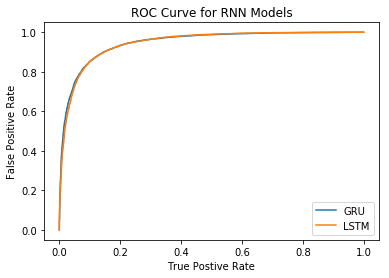

In [24]:
y_pred_list = [y_test_pred_gru, y_test_pred_lstm]
label_list = ["GRU", "LSTM"]
pred_label = zip(y_pred_list, label_list)
for y_pred, lbl in pred_label:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label = lbl)

plt.xlabel("True Postive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve for RNN Models")
plt.legend()
plt.show()

In [25]:
lstm_model_json = lstm_model.to_json()
with open("models/lstm_model.json", "w") as json_file:
    json_file.write(lstm_model_json)
# serialize weights to HDF5
lstm_model.save_weights("models/lstm_model.h5")
print("Saved lstm model to disk")

Saved lstm model to disk
